In [1]:
from typing import Any, Dict, Union, NamedTuple

import numpy as np
import tensorflow_datasets as tfds
import rlds
import reverb
from rlds import transformations
import tensorflow_datasets as tfds
import tree

import abc
import dataclasses
from typing import Dict, Optional

from rlds import rlds_types
import tensorflow as tf
from PIL import Image
from IPython import display

# @title Transformation definitions

def _features_to_tensor_spec(
    feature: tfds.features.FeatureConnector
) -> tf.TensorSpec:
  """Converts a tfds Feature into a TensorSpec."""

  def _get_feature_spec(nested_feature: tfds.features.FeatureConnector):
    if isinstance(nested_feature, tf.DType):
      return tf.TensorSpec(shape=(), dtype=nested_feature)
    else:
      return nested_feature.get_tensor_spec()

  # FeaturesDict can sometimes be a plain dictionary, so we use tf.nest to
  # make sure we deal with the nested structure.
  return tf.nest.map_structure(_get_feature_spec, feature)


def _encoded_feature(feature: Optional[tfds.features.FeatureConnector],
                     image_encoding: Optional[str],
                     tensor_encoding: Optional[tfds.features.Encoding]):
  """Adds encoding to Images and/or Tensors."""
  def _apply_encoding(feature: tfds.features.FeatureConnector,
                      image_encoding: Optional[str],
                      tensor_encoding: Optional[tfds.features.Encoding]):
    if image_encoding and isinstance(feature, tfds.features.Image):
      return tfds.features.Image(
          shape=feature.shape,
          dtype=feature.dtype,
          use_colormap=feature.use_colormap,
          encoding_format=image_encoding)
    if tensor_encoding and isinstance(
        feature, tfds.features.Tensor) and feature.dtype != tf.string:
      return tfds.features.Tensor(
          shape=feature.shape, dtype=feature.dtype, encoding=tensor_encoding)
    return feature

  if not feature:
    return None
  return tf.nest.map_structure(
      lambda x: _apply_encoding(x, image_encoding, tensor_encoding), feature)


@dataclasses.dataclass
class RLDSSpec(metaclass=abc.ABCMeta):
  """Specification of an RLDS Dataset.

  It is used to hold a spec that can be converted into a TFDS DatasetInfo or
  a `tf.data.Dataset` spec.
  """
  observation_info: Optional[tfds.features.FeatureConnector] = None
  action_info: Optional[tfds.features.FeatureConnector] = None
  reward_info: Optional[tfds.features.FeatureConnector] = None
  discount_info: Optional[tfds.features.FeatureConnector] = None
  step_metadata_info: Optional[tfds.features.FeaturesDict] = None
  episode_metadata_info: Optional[tfds.features.FeaturesDict] = None

  def step_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    step = {}
    if self.observation_info:
      step[rlds_types.OBSERVATION] = _features_to_tensor_spec(
          self.observation_info)
    if self.action_info:
      step[rlds_types.ACTION] = _features_to_tensor_spec(
          self.action_info)
    if self.discount_info:
      step[rlds_types.DISCOUNT] = _features_to_tensor_spec(
          self.discount_info)
    if self.reward_info:
      step[rlds_types.REWARD] = _features_to_tensor_spec(
          self.reward_info)
    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step[k] = _features_to_tensor_spec(v)

    step[rlds_types.IS_FIRST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_LAST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_TERMINAL] = tf.TensorSpec(shape=(), dtype=bool)
    return step

  def episode_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    episode = {}
    episode[rlds_types.STEPS] = tf.data.DatasetSpec(
        element_spec=self.step_tensor_spec())
    if self.episode_metadata_info:
      for k, v in self.episode_metadata_info.items():
        episode[k] = _features_to_tensor_spec(v)
    return episode

  def to_dataset_config(
      self,
      name: str,
      image_encoding: Optional[str] = None,
      tensor_encoding: Optional[tfds.features.Encoding] = None,
      citation: Optional[str] = None,
      homepage: Optional[str] = None,
      description: Optional[str] = None,
      overall_description: Optional[str] = None,
  ) -> tfds.rlds.rlds_base.DatasetConfig:
    """Obtains the DatasetConfig for TFDS from the Spec."""
    return tfds.rlds.rlds_base.DatasetConfig(
        name=name,
        description=description,
        overall_description=overall_description,
        homepage=homepage,
        citation=citation,
        observation_info=_encoded_feature(self.observation_info, image_encoding,
                                          tensor_encoding),
        action_info=_encoded_feature(self.action_info, image_encoding,
                                     tensor_encoding),
        reward_info=_encoded_feature(self.reward_info, image_encoding,
                                     tensor_encoding),
        discount_info=_encoded_feature(self.discount_info, image_encoding,
                                       tensor_encoding),
        step_metadata_info=_encoded_feature(self.step_metadata_info,
                                            image_encoding, tensor_encoding),
        episode_metadata_info=_encoded_feature(self.episode_metadata_info,
                                               image_encoding, tensor_encoding))

  def to_features_dict(self):
    """Returns a TFDS FeaturesDict representing the dataset config."""
    step_config = {
        rlds_types.IS_FIRST: tf.bool,
        rlds_types.IS_LAST: tf.bool,
        rlds_types.IS_TERMINAL: tf.bool,
    }

    if self.observation_info:
      step_config[rlds_types.OBSERVATION] = self.observation_info
    if self.action_info:
      step_config[rlds_types.ACTION] = self.action_info
    if self.discount_info:
      step_config[rlds_types.DISCOUNT] = self.discount_info
    if self.reward_info:
      step_config[rlds_types.REWARD] = self.reward_info

    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step_config[k] = v

    if self.episode_metadata_info:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
          **self.episode_metadata_info,
      })
    else:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
      })

RLDS_SPEC = RLDSSpec
TENSOR_SPEC = Union[tf.TensorSpec, dict[str, tf.TensorSpec]]


@dataclasses.dataclass
class TrajectoryTransform(metaclass=abc.ABCMeta):
  """Specification the TrajectoryTransform applied to a dataset of episodes.

  A TrajectoryTransform is a set of rules transforming a dataset
  of RLDS episodes to a dataset of trajectories.
  This involves three distinct stages:
  - An optional `episode_to_steps_map_fn(episode)` is called at the episode
    level, and can be used to select or modify steps.
    - Augmentation: an `episode_key` could be propagated to `steps` for
      debugging.
    - Selection: Particular steps can be selected.
    - Stripping: Features can be removed from steps. Prefer using `step_map_fn`.
  - An optional `step_map_fn` is called at the flattened steps dataset for each
    step, and can be used to featurize a step, e.g. add/remove features, or
    augument images
  - A `pattern` leverages DM patterns to set a rule of slicing an episode to a
    dataset of overlapping trajectories.

  Importantly, each TrajectoryTransform must define a `expected_tensor_spec`
  which specifies a nested TensorSpec of the resulting dataset. This is what
  this TrajectoryTransform will produce, and can be used as an interface with
  a neural network.
  """
  episode_dataset_spec: RLDS_SPEC
  episode_to_steps_fn_dataset_spec: RLDS_SPEC
  steps_dataset_spec: Any
  pattern: reverb.structured_writer.Pattern
  episode_to_steps_map_fn: Any
  expected_tensor_spec: TENSOR_SPEC
  step_map_fn: Optional[Any] = None

  def get_for_cached_trajectory_transform(self):
    """Creates a copy of this traj transform to use with caching.

    The returned TrajectoryTransfrom copy will be initialized with the default
    version of the `episode_to_steps_map_fn`, because the effect of that
    function has already been materialized in the cached copy of the dataset.
    Returns:
      trajectory_transform: A copy of the TrajectoryTransform with overridden
        `episode_to_steps_map_fn`.
    """
    traj_copy = dataclasses.replace(self)
    traj_copy.episode_dataset_spec = traj_copy.episode_to_steps_fn_dataset_spec
    traj_copy.episode_to_steps_map_fn = lambda e: e[rlds_types.STEPS]
    return traj_copy

  def transform_episodic_rlds_dataset(self, episodes_dataset: tf.data.Dataset):
    """Applies this TrajectoryTransform to the dataset of episodes."""

    # Convert the dataset of episodes to the dataset of steps.
    steps_dataset = episodes_dataset.map(
        self.episode_to_steps_map_fn, num_parallel_calls=tf.data.AUTOTUNE
    ).flat_map(lambda x: x)

    return self._create_pattern_dataset(steps_dataset)

  def transform_steps_rlds_dataset(
      self, steps_dataset: tf.data.Dataset
  ) -> tf.data.Dataset:
    """Applies this TrajectoryTransform to the dataset of episode steps."""

    return self._create_pattern_dataset(steps_dataset)

  def create_test_dataset(
      self,
  ) -> tf.data.Dataset:
    """Creates a test dataset of trajectories.

    It is guaranteed that the structure of this dataset will be the same as
    when flowing real data. Hence this is a useful construct for tests or
    initialization of JAX models.
    Returns:
      dataset: A test dataset made of zeros structurally identical to the
        target dataset of trajectories.
    """
    zeros = transformations.zeros_from_spec(self.expected_tensor_spec)

    return tf.data.Dataset.from_tensors(zeros)

  def _create_pattern_dataset(
      self, steps_dataset: tf.data.Dataset) -> tf.data.Dataset:
    """Create PatternDataset from the `steps_dataset`."""
    config = create_structured_writer_config('temp', self.pattern)

    # Further transform each step if the `step_map_fn` is provided.
    if self.step_map_fn:
      steps_dataset = steps_dataset.map(self.step_map_fn)
    pattern_dataset = reverb.PatternDataset(
        input_dataset=steps_dataset,
        configs=[config],
        respect_episode_boundaries=True,
        is_end_of_episode=lambda x: x[rlds_types.IS_LAST])
    return pattern_dataset


class TrajectoryTransformBuilder(object):
  """Facilitates creation of the `TrajectoryTransform`."""

  def __init__(self,
               dataset_spec: RLDS_SPEC,
               episode_to_steps_map_fn=lambda e: e[rlds_types.STEPS],
               step_map_fn=None,
               pattern_fn=None,
               expected_tensor_spec=None):
    self._rds_dataset_spec = dataset_spec
    self._steps_spec = None
    self._episode_to_steps_map_fn = episode_to_steps_map_fn
    self._step_map_fn = step_map_fn
    self._pattern_fn = pattern_fn
    self._expected_tensor_spec = expected_tensor_spec

  def build(self,
            validate_expected_tensor_spec: bool = True) -> TrajectoryTransform:
    """Creates `TrajectoryTransform` from a `TrajectoryTransformBuilder`."""

    if validate_expected_tensor_spec and self._expected_tensor_spec is None:
      raise ValueError('`expected_tensor_spec` must be set.')

    episode_ds = zero_episode_dataset_from_spec(self._rds_dataset_spec)

    steps_ds = episode_ds.flat_map(self._episode_to_steps_map_fn)

    episode_to_steps_fn_dataset_spec = self._rds_dataset_spec

    if self._step_map_fn is not None:
      steps_ds = steps_ds.map(self._step_map_fn)

    zeros_spec = transformations.zeros_from_spec(steps_ds.element_spec)  # pytype: disable=wrong-arg-types

    ref_step = reverb.structured_writer.create_reference_step(zeros_spec)

    pattern = self._pattern_fn(ref_step)

    steps_ds_spec = steps_ds.element_spec

    target_tensor_structure = create_reverb_table_signature(
        'temp_table', steps_ds_spec, pattern)

    if (validate_expected_tensor_spec and
        self._expected_tensor_spec != target_tensor_structure):
      raise RuntimeError(
          'The tensor spec of the TrajectoryTransform doesn\'t '
          'match the expected spec.\n'
          'Expected:\n%s\nActual:\n%s\n' %
          (str(self._expected_tensor_spec).replace('TensorSpec',
                                                   'tf.TensorSpec'),
           str(target_tensor_structure).replace('TensorSpec', 'tf.TensorSpec')))

    return TrajectoryTransform(
        episode_dataset_spec=self._rds_dataset_spec,
        episode_to_steps_fn_dataset_spec=episode_to_steps_fn_dataset_spec,
        steps_dataset_spec=steps_ds_spec,
        pattern=pattern,
        episode_to_steps_map_fn=self._episode_to_steps_map_fn,
        step_map_fn=self._step_map_fn,
        expected_tensor_spec=target_tensor_structure)

def zero_episode_dataset_from_spec(rlds_spec: RLDS_SPEC):
  """Creates a zero valued dataset of episodes for the given RLDS Spec."""

  def add_steps(episode, step_spec):
    episode[rlds_types.STEPS] = transformations.zero_dataset_like(
        tf.data.DatasetSpec(step_spec))
    if 'fake' in episode:
      del episode['fake']
    return episode

  episode_without_steps_spec = {
      k: v
      for k, v in rlds_spec.episode_tensor_spec().items()
      if k != rlds_types.STEPS
  }

  if episode_without_steps_spec:
    episodes_dataset = transformations.zero_dataset_like(
        tf.data.DatasetSpec(episode_without_steps_spec))
  else:
    episodes_dataset = tf.data.Dataset.from_tensors({'fake': ''})

  episodes_dataset_with_steps = episodes_dataset.map(
      lambda episode: add_steps(episode, rlds_spec.step_tensor_spec()))
  return episodes_dataset_with_steps


def create_reverb_table_signature(table_name: str, steps_dataset_spec,
                                  pattern: reverb.structured_writer.Pattern) -> reverb.reverb_types.SpecNest:
  config = create_structured_writer_config(table_name, pattern)
  reverb_table_spec = reverb.structured_writer.infer_signature(
      [config], steps_dataset_spec)
  return reverb_table_spec


def create_structured_writer_config(table_name: str,
                                    pattern: reverb.structured_writer.Pattern) -> Any:
  config = reverb.structured_writer.create_config(
      pattern=pattern, table=table_name, conditions=[])
  return config

def n_step_pattern_builder(n: int) -> Any:
  """Creates trajectory of length `n` from all fields of a `ref_step`."""

  def transform_fn(ref_step):
    traj = {}
    for key in ref_step:
      if isinstance(ref_step[key], dict):
        transformed_entry = tree.map_structure(lambda ref_node: ref_node[-n:],
                                               ref_step[key])
        traj[key] = transformed_entry
      else:
        traj[key] = ref_step[key][-n:]

    return traj

  return transform_fn

def dataset2path(dataset_name):
  if dataset_name == 'robo_net':
    version = '1.0.0'
  elif dataset_name == 'language_table':
    version = '0.0.1'
  else:
    version = '0.1.0'
  return f'gs://gresearch/robotics/{dataset_name}/{version}'

def dataset2path_ours(dataset_name):
  if dataset_name == 'robo_net':
    version = '1.0.0'
  elif dataset_name == 'language_table':
    version = '0.0.1'
  else:
    version = '0.1.0'
  return f'/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/{dataset_name}/{version}'

def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

def debug_step_fn(step):
    print("Keys in step: ", list(step.keys()))
    return step

2024-09-23 11:33:06.036630: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 11:33:06.040200: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 11:33:06.083917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 11:33:06.083941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 11:33:06.085300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Dataloader

The datat loader begins here, no need to look above

### Load one dataset

In [2]:
#load the dataset
import os
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-bundle.crt'
import tensorflow as tf 
import tensorflow_datasets as tfds

# load raw dataset --> replace this with tfds.load(<dataset_name>) on your
# local machine!
dataset_name = 'bridge'
data_dir= '/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets'
ds, ds_info = tfds.load(dataset_name, data_dir = data_dir, download=False, split='train', with_info=True)

2024-09-23 11:33:21.535582: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [3]:
# To look at what's inside the dataset
ds_info

tfds.core.DatasetInfo(
    name='bridge',
    full_name='bridge/0.1.0',
    description="""
    WidowX interacting with toy kitchens
    """,
    homepage='https://rail-berkeley.github.io/bridgedata/',
    data_dir='/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/bridge/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=387.49 GiB,
    features=FeaturesDict({
        'episode_metadata': FeaturesDict({
            'episode_id': Scalar(shape=(), dtype=int32),
            'file_path': string,
            'has_image_0': Scalar(shape=(), dtype=bool),
            'has_image_1': Scalar(shape=(), dtype=bool),
            'has_image_2': Scalar(shape=(), dtype=bool),
            'has_image_3': Scalar(shape=(), dtype=bool),
            'has_language': Scalar(shape=(), dtype=bool),
        }),
        'steps': Dataset({
            'action': Tensor(shape=(7,), dtype=float32),
            'discount': Scalar(shape=(), dtype=float32),
            'is_fir

### Retrive all steps in the dataset

In [7]:
# Take all the steps in the eposide
def episode2steps(episode):
  return episode['steps']

def step_map_fn(step):
  return {
      'observation': {
          'image': tf.image.resize(step['observation']['image'], (128, 128)),
      }
  }

# convert RLDS episode dataset to individual steps & reformat
ds_steps = ds.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)
# obtain the image in each step
ds_mapped = ds_steps.map(step_map_fn, num_parallel_calls=tf.data.AUTOTUNE)


# # shuffle, repeat, pre-fetch, batch
# ds = ds.cache()         # optionally keep full dataset in memory
# ds = ds.shuffle(100)    # set shuffle buffer size
# ds = ds.repeat()        # ensure that data never runs out

In [4]:
num_steps = sum(1 for _ in ds_mapped.as_numpy_iterator())
print(f"Number of steps: {num_steps}")

### Retrive the first and the last step in the dataset

In [4]:
# Take just take the first and the last step
def episode2steps(episode):
  return episode['steps']

def filter_first_last_terminal(step):
    return step['is_first'] | step['is_last']

def step_map_fn(step):
  return {
      'observation': {
          'image': step['observation']['image'],
          'language': step['observation']['natural_language_instruction'],
      },
      
  }

# first map to steps
ds_steps = ds.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)

# then filtered out the first and the last image
filtered_ds = ds_steps.filter(filter_first_last_terminal)

# obtain the image in each step
ds_mapped = filtered_ds.map(step_map_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
for sample in ds_mapped.take(6):  # 取出一个样本
   print(sample['observation']['language'])

tf.Tensor(b'place the white sponge in the ceramic bowl', shape=(), dtype=string)
tf.Tensor(b'place the white sponge in the ceramic bowl', shape=(), dtype=string)
tf.Tensor(b'move the arm in a circular motion', shape=(), dtype=string)
tf.Tensor(b'move the arm in a circular motion', shape=(), dtype=string)
tf.Tensor(b'place the bottle in the ceramic bowl', shape=(), dtype=string)
tf.Tensor(b'place the bottle in the ceramic bowl', shape=(), dtype=string)


### Run this only in pytorch training code


In [7]:
import tqdm

for i, batch in tqdm.tqdm(
    enumerate(ds_mapped.prefetch(3).batch(4).as_numpy_iterator())):
    print(batch.keys())
    
    if i == 1: break

1it [00:03,  3.26s/it]

dict_keys(['observation'])
dict_keys(['observation'])


### load another dataset and then add them together

In [8]:
dataset_name = 'bridge'
data_dir= '/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets'
ds2, ds_info = tfds.load(dataset_name, data_dir = data_dir, download=False, split='train', with_info=True)

print(ds_info)

tfds.core.DatasetInfo(
    name='bridge',
    full_name='bridge/0.1.0',
    description="""
    WidowX interacting with toy kitchens
    """,
    homepage='https://rail-berkeley.github.io/bridgedata/',
    data_dir='/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/bridge/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=387.49 GiB,
    features=FeaturesDict({
        'episode_metadata': FeaturesDict({
            'episode_id': Scalar(shape=(), dtype=int32),
            'file_path': string,
            'has_image_0': Scalar(shape=(), dtype=bool),
            'has_image_1': Scalar(shape=(), dtype=bool),
            'has_image_2': Scalar(shape=(), dtype=bool),
            'has_image_3': Scalar(shape=(), dtype=bool),
            'has_language': Scalar(shape=(), dtype=bool),
        }),
        'steps': Dataset({
            'action': Tensor(shape=(7,), dtype=float32),
            'discount': Scalar(shape=(), dtype=float32),
            'is_fir

In [8]:
# it looks like I need to create a step_map_fn_mutex for every dataset
def step_map_fn_mutex(step):
  # reformat to align specs of both datasets
  return {
      'observation': {
          'image': tf.image.resize(step['observation']['image_0'], (128, 128)), # change the key here!!!!
      }
  }


ds2 = ds2.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)
ds2 = ds2.map(step_map_fn_mutex, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle, repeat, pre-fetch, batch
ds2 = ds2.cache()         # optionally keep full dataset in memory
ds2 = ds2.shuffle(100)    # set shuffle buffer size
ds2 = ds2.repeat()        # ensure that data never runs out

In [9]:
# interleave datasets w/ equal sampling weight
ds_combined = tf.data.Dataset.sample_from_datasets([ds, ds2], [0.5, 0.5])

### Run this in the pytorch code

In [ ]:
import tqdm

for i, batch in tqdm.tqdm(
    enumerate(ds_combined.prefetch(3).batch(4).as_numpy_iterator())):
    print(batch.shape)
    if i == 10000: break

0it [00:00, ?it/s]2024-09-16 17:28:30.379368: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at example_parsing_ops.cc:98 : INVALID_ARGUMENT: Feature: episode_metadata/episode_id (data type: int64) is required but could not be found.
0it [00:00, ?it/s]
2024-09-16 17:28:30.847736: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at example_parsing_ops.cc:98 : INVALID_ARGUMENT: Feature: episode_metadata/episode_id (data type: int64) is required but could not be found.
2024-09-16 17:28:30.847920: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at example_parsing_ops.cc:98 : INVALID_ARGUMENT: Feature: episode_metadata/episode_id (data type: int64) is required but could not be found.
2024-09-16 17:28:31.746963: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at example_parsing_ops.cc:98 : INVALID_ARGUMENT: Feature: episode_metadata/episode_id (data type: int64) is required but could not be found.


In [3]:
ds = tfds.load(dataset_name, data_dir = data_dir, split='train')

def debug_step_fn(step):
    print("Keys in step['action']: ", list(step['action'].keys()))
    print("Keys in step['action']: ", list(step['observation'].keys()))
    print("Keys in step: ", list(step.keys()))
    return step

ds = ds.map(
    episode2steps, num_parallel_calls=tf.data.AUTOTUNE).flat_map(lambda x: x)

ds = ds.map(debug_step_fn, num_parallel_calls=tf.data.AUTOTUNE)


Keys in step['action']:  ['future/axis_angle_residual', 'future/target_close', 'future/xyz_residual']
Keys in step['action']:  ['episode_success', 'image', 'natural_language_embedding', 'natural_language_instruction', 'present/autonomous', 'present/axis_angle', 'present/intervention', 'present/sensed_close', 'present/xyz', 'sequence_length']
Keys in step:  ['action', 'is_first', 'is_last', 'is_terminal', 'observation', 'reward']


# Dataloader to produce trajectories

Seems I do not need to use it right now

In [4]:
# load the dataset (tfds dataset object)
import tensorflow_datasets as tfds
mt_opt_builder = tfds.builder_from_directory(builder_dir=dataset2path_ours('bridge'))
mt_opt_episodic_dataset = mt_opt_builder.as_dataset(split='train')

In [5]:
mt_opt_info = mt_opt_builder.info
print(mt_opt_info)

tfds.core.DatasetInfo(
    name='bridge',
    full_name='bridge/0.1.0',
    description="""
    WidowX interacting with toy kitchens
    """,
    homepage='https://rail-berkeley.github.io/bridgedata/',
    data_dir='/data/home/acw694/CLIPort_new_loss/scratch/tensorflow_datasets/bridge/0.1.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=387.49 GiB,
    features=FeaturesDict({
        'steps': Dataset({
            'action': FeaturesDict({
                'open_gripper': bool,
                'rotation_delta': Tensor(shape=(3,), dtype=float32),
                'terminate_episode': float32,
                'world_vector': Tensor(shape=(3,), dtype=float32),
            }),
            'is_first': bool,
            'is_last': bool,
            'is_terminal': bool,
            'observation': FeaturesDict({
                'image': Image(shape=(480, 640, 3), dtype=uint8),
                'natural_language_embedding': Tensor(shape=(512,), dtype=float32),
        

In [9]:
# The RLDSSpec for the `mt_opt` dataset.
mt_opt_rlds_spec = RLDSSpec(
    observation_info=ds_info.features['steps']['observation'],
    action_info=ds_info.features['steps']['action'],
)

def mt_opt_step_map_fn(step):
  transformed_step = {}
  transformed_step['observation'] = tf.cast(tf.image.resize(step['observation']['image'], [240, 320]), tf.uint8)  # Resize to be compatible with robo_net trajectory
  transformed_step['is_first'] = step['is_first']
  transformed_step['is_last'] = step['is_last']
  transformed_step['is_terminal'] = step['is_terminal']
  return transformed_step

# The following will create a trajectories of length 3.
trajectory_length = 3
trajectory_transform = TrajectoryTransformBuilder(mt_opt_rlds_spec, step_map_fn=mt_opt_step_map_fn, pattern_fn=n_step_pattern_builder(trajectory_length)).build(validate_expected_tensor_spec=False)
trajectory_dataset = trajectory_transform.transform_episodic_rlds_dataset(mt_opt_episodic_dataset)

KeyError: in user code:

    File "/tmp/3875567.1.short.q/ipykernel_236513/1018894643.py", line 9, in mt_opt_step_map_fn  *
        transformed_step['observation'] = tf.cast(tf.image.resize(step['observation']['image'], [240, 320]), tf.uint8)  # Resize to be compatible with robo_net trajectory

    KeyError: 'image'


In [ ]:
trajectory_iter = iter(trajectory_dataset)

In [ ]:
trajectory = next(trajectory_iter)

In [ ]:
trajectory

In [ ]:
# Note that the leading dimension (3) corresponds to the trajectory_length
trajectory['observation'].shape

In [7]:
images = [trajectory['observation'][id] for id in range(trajectory['observation'].shape[0])]
images = [Image.fromarray(image.numpy()) for image in images]

display.Image(as_gif(images))

NameError: name 'trajectory' is not defined

In [14]:
import tensorflow_datasets as tfds
robo_net_builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/robo_net/1.0.0/')

robo_net_builder_episodic_dataset = robo_net_builder.as_dataset(split='train[:10]')
episodes = list(iter(robo_net_builder_episodic_dataset))

In [15]:
# The following will create a trajectories of length 3.
trajectory_length = 3

robo_net_rlds_spec = RLDSSpec(
    observation_info=robo_net_builder.info.features['steps']['observation'],
    action_info=robo_net_builder.info.features['steps']['action'],
)

def robo_net_step_map_fn(step):
  transformed_step = {}
  transformed_step['observation'] = step['observation']['image']
  transformed_step['is_first'] = step['is_first']
  transformed_step['is_last'] = step['is_last']
  transformed_step['is_terminal'] = step['is_terminal']
  return transformed_step

robo_net_trajectory_transform = TrajectoryTransformBuilder(robo_net_rlds_spec,
                                                                          step_map_fn=robo_net_step_map_fn,
                                                                          pattern_fn=n_step_pattern_builder(trajectory_length)).build(validate_expected_tensor_spec=False)


def mt_opt_step_map_fn(step):
  transformed_step = {}
  transformed_step['observation'] = tf.cast(tf.image.resize(step['observation']['image'], [240, 320]), tf.uint8)  # Resize to be compatible with robo_net trajectory
  transformed_step['is_first'] = step['is_first']
  transformed_step['is_last'] = step['is_last']
  transformed_step['is_terminal'] = step['is_terminal']
  return transformed_step

mt_opt_trajectory_transform = TrajectoryTransformBuilder(mt_opt_rlds_spec,
                                                         step_map_fn=mt_opt_step_map_fn,
                                                         pattern_fn=n_step_pattern_builder(trajectory_length)).build(validate_expected_tensor_spec=False)

In [16]:
# Validate that the specs are equal
assert robo_net_trajectory_transform.expected_tensor_spec == mt_opt_trajectory_transform.expected_tensor_spec

In [17]:
# Create trajectory datasets for the two normalized representations:
robo_net_trajectory_dataset = robo_net_trajectory_transform.transform_episodic_rlds_dataset(robo_net_builder_episodic_dataset)
mt_opt_trajectory_dataset = mt_opt_trajectory_transform.transform_episodic_rlds_dataset(mt_opt_episodic_dataset)


In [18]:
combined_dataset = tf.data.Dataset.sample_from_datasets([robo_net_trajectory_dataset, mt_opt_trajectory_dataset])
combined_dataset = combined_dataset.batch(2)
combined_dataset_it = iter(combined_dataset)

In [19]:
example = next(combined_dataset_it)

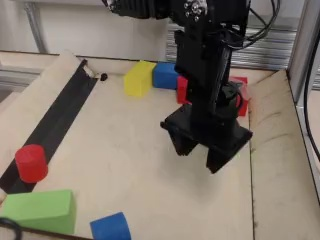

In [20]:
# First element of the batch returns a robot_net trajectory
Image.fromarray(example['observation'].numpy()[0][0])

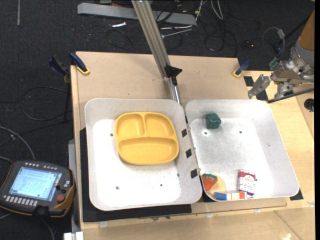

In [21]:
# Second element of the batch returns a mt_opt trajectory
Image.fromarray(example['observation'].numpy()[1][0])